<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:07:21] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


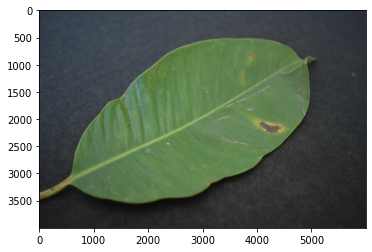

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

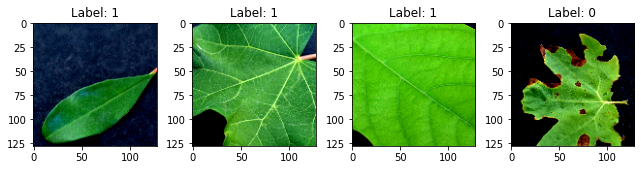

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:07:28] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:07:30] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2560202212384843 samples/sec                   batch loss = 1.0882904529571533 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2716880199920093 samples/sec                   batch loss = 0.3187170922756195 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2713332997892177 samples/sec                   batch loss = 0.4800167977809906 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2802900070977077 samples/sec                   batch loss = 0.43647581338882446 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2686128562053365 samples/sec                   batch loss = 0.816551923751831 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.277340789937209 samples/sec                   batch loss = 0.9070704579353333 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.2698715074914793 samples/sec                   batch loss = 0.33534911274909973 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2692244901417546 samples/sec                   batch loss = 1.3120909929275513 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2727238245340247 samples/sec                   batch loss = 0.7447986602783203 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2632566830440413 samples/sec                   batch loss = 0.5005396604537964 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2750270133228234 samples/sec                   batch loss = 0.5243514776229858 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2779996154700481 samples/sec                   batch loss = 0.4872848391532898 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2735216271961267 samples/sec                   batch loss = 0.7271502017974854 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2709057016321197 samples/sec                   batch loss = 0.42018821835517883 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2714837980172777 samples/sec                   batch loss = 0.7709434628486633 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2749339971588116 samples/sec                   batch loss = 0.28960177302360535 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2709892725250156 samples/sec                   batch loss = 0.9459769129753113 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.2743381437833234 samples/sec                   batch loss = 0.5612564086914062 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.270910900422379 samples/sec                   batch loss = 0.5295385718345642 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.27200590405725 samples/sec                   batch loss = 0.9362697601318359 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.269584183047815 samples/sec                   batch loss = 0.47428086400032043 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.26728059151186 samples/sec                   batch loss = 1.170520544052124 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2631544393279956 samples/sec                   batch loss = 0.3567151427268982 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2738362698435959 samples/sec                   batch loss = 0.8897556662559509 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2777609547722466 samples/sec                   batch loss = 1.0889283418655396 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.27347609714546 samples/sec                   batch loss = 0.81634521484375 | accuracy = 0.6442307692307693


Epoch[1] Batch[135] Speed: 1.2760916577523187 samples/sec                   batch loss = 0.5065617561340332 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2798399614183986 samples/sec                   batch loss = 0.6292677521705627 | accuracy = 0.6446428571428572


Epoch[1] Batch[145] Speed: 1.2728667333199095 samples/sec                   batch loss = 0.6547253131866455 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.2711242800628728 samples/sec                   batch loss = 0.9244338870048523 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.2804845583655924 samples/sec                   batch loss = 1.4554789066314697 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.2759418134826306 samples/sec                   batch loss = 0.6306174993515015 | accuracy = 0.6546875


Epoch[1] Batch[165] Speed: 1.262801231458091 samples/sec                   batch loss = 0.48172515630722046 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2708027935941213 samples/sec                   batch loss = 0.3267309367656708 | accuracy = 0.6514705882352941


Epoch[1] Batch[175] Speed: 1.2682745179889388 samples/sec                   batch loss = 0.3206687867641449 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2697659799281622 samples/sec                   batch loss = 0.3499164879322052 | accuracy = 0.6583333333333333


Epoch[1] Batch[185] Speed: 1.2683276351176402 samples/sec                   batch loss = 0.24985848367214203 | accuracy = 0.6608108108108108


Epoch[1] Batch[190] Speed: 1.2684201692616388 samples/sec                   batch loss = 0.4646437168121338 | accuracy = 0.6592105263157895


Epoch[1] Batch[195] Speed: 1.267484901734733 samples/sec                   batch loss = 0.4421984851360321 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.2649121931381526 samples/sec                   batch loss = 0.6811787486076355 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2728981196144649 samples/sec                   batch loss = 0.7534695267677307 | accuracy = 0.6597560975609756


Epoch[1] Batch[210] Speed: 1.2693638289457985 samples/sec                   batch loss = 0.5435147881507874 | accuracy = 0.6619047619047619


Epoch[1] Batch[215] Speed: 1.2681619704006628 samples/sec                   batch loss = 0.9536986351013184 | accuracy = 0.663953488372093


Epoch[1] Batch[220] Speed: 1.2687564743407762 samples/sec                   batch loss = 0.4118063747882843 | accuracy = 0.6659090909090909


Epoch[1] Batch[225] Speed: 1.2774956321511746 samples/sec                   batch loss = 0.5197619795799255 | accuracy = 0.6655555555555556


Epoch[1] Batch[230] Speed: 1.273557492861619 samples/sec                   batch loss = 1.058349609375 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2643180460859358 samples/sec                   batch loss = 0.2241193801164627 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.261010190172049 samples/sec                   batch loss = 1.1366667747497559 | accuracy = 0.6645833333333333


Epoch[1] Batch[245] Speed: 1.2705813427411337 samples/sec                   batch loss = 0.9724433422088623 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.2631133562824455 samples/sec                   batch loss = 0.7565949559211731 | accuracy = 0.665


Epoch[1] Batch[255] Speed: 1.2685964529964486 samples/sec                   batch loss = 0.27205416560173035 | accuracy = 0.6676470588235294


Epoch[1] Batch[260] Speed: 1.2713352265580078 samples/sec                   batch loss = 0.6199290156364441 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.2705656583633262 samples/sec                   batch loss = 0.5063051581382751 | accuracy = 0.6632075471698113


Epoch[1] Batch[270] Speed: 1.2673144790911288 samples/sec                   batch loss = 0.5501660108566284 | accuracy = 0.6638888888888889


Epoch[1] Batch[275] Speed: 1.268367332050089 samples/sec                   batch loss = 0.4561336934566498 | accuracy = 0.6636363636363637


Epoch[1] Batch[280] Speed: 1.2700740580588292 samples/sec                   batch loss = 0.42796722054481506 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2677444534532878 samples/sec                   batch loss = 0.9661762118339539 | accuracy = 0.6622807017543859


Epoch[1] Batch[290] Speed: 1.2637359748542603 samples/sec                   batch loss = 0.5555320382118225 | accuracy = 0.6620689655172414


Epoch[1] Batch[295] Speed: 1.2706638123740628 samples/sec                   batch loss = 1.5691767930984497 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.2671339576803704 samples/sec                   batch loss = 0.4547100067138672 | accuracy = 0.6641666666666667


Epoch[1] Batch[305] Speed: 1.2663008377162437 samples/sec                   batch loss = 0.43747174739837646 | accuracy = 0.6672131147540984


Epoch[1] Batch[310] Speed: 1.2701110759421559 samples/sec                   batch loss = 0.4379957616329193 | accuracy = 0.6693548387096774


Epoch[1] Batch[315] Speed: 1.264549232857295 samples/sec                   batch loss = 0.5135953426361084 | accuracy = 0.669047619047619


Epoch[1] Batch[320] Speed: 1.2682201590361015 samples/sec                   batch loss = 0.3715497553348541 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.2673540168909367 samples/sec                   batch loss = 0.5479572415351868 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.26446164638821 samples/sec                   batch loss = 0.3276137709617615 | accuracy = 0.671969696969697


Epoch[1] Batch[335] Speed: 1.2566198641651638 samples/sec                   batch loss = 0.5970605611801147 | accuracy = 0.6723880597014925


Epoch[1] Batch[340] Speed: 1.2615048520730348 samples/sec                   batch loss = 0.5153771042823792 | accuracy = 0.6727941176470589


Epoch[1] Batch[345] Speed: 1.2688201871177498 samples/sec                   batch loss = 0.2538302540779114 | accuracy = 0.6746376811594202


Epoch[1] Batch[350] Speed: 1.2703837286361417 samples/sec                   batch loss = 0.5485644340515137 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.269163040983521 samples/sec                   batch loss = 0.8891640305519104 | accuracy = 0.6753521126760563


Epoch[1] Batch[360] Speed: 1.269409161464542 samples/sec                   batch loss = 1.351698398590088 | accuracy = 0.6722222222222223


Epoch[1] Batch[365] Speed: 1.2686982364814898 samples/sec                   batch loss = 0.465381920337677 | accuracy = 0.6726027397260274


Epoch[1] Batch[370] Speed: 1.2623191341250797 samples/sec                   batch loss = 0.3646978735923767 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.2646568502557625 samples/sec                   batch loss = 0.3857686221599579 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.2584780210622266 samples/sec                   batch loss = 0.26748427748680115 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2607926125432858 samples/sec                   batch loss = 0.5039076805114746 | accuracy = 0.675974025974026


Epoch[1] Batch[390] Speed: 1.267643589181171 samples/sec                   batch loss = 0.8026425838470459 | accuracy = 0.6730769230769231


Epoch[1] Batch[395] Speed: 1.256331636729611 samples/sec                   batch loss = 1.9598978757858276 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.2595240851507499 samples/sec                   batch loss = 0.29245707392692566 | accuracy = 0.673125


Epoch[1] Batch[405] Speed: 1.2668250083153907 samples/sec                   batch loss = 0.2584013044834137 | accuracy = 0.6728395061728395


Epoch[1] Batch[410] Speed: 1.2669342571758098 samples/sec                   batch loss = 0.24269121885299683 | accuracy = 0.675


Epoch[1] Batch[415] Speed: 1.261860941510486 samples/sec                   batch loss = 0.12047155201435089 | accuracy = 0.6765060240963855


Epoch[1] Batch[420] Speed: 1.2673233820608631 samples/sec                   batch loss = 0.7328739166259766 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2662785686413474 samples/sec                   batch loss = 0.5211822986602783 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2602895150550713 samples/sec                   batch loss = 0.6358914375305176 | accuracy = 0.6790697674418604


Epoch[1] Batch[435] Speed: 1.2662539110945268 samples/sec                   batch loss = 0.4981534481048584 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.267256469254565 samples/sec                   batch loss = 0.5662233233451843 | accuracy = 0.6795454545454546


Epoch[1] Batch[445] Speed: 1.2641415205429205 samples/sec                   batch loss = 0.2751549184322357 | accuracy = 0.6825842696629213


Epoch[1] Batch[450] Speed: 1.2638842987845187 samples/sec                   batch loss = 0.21155428886413574 | accuracy = 0.6838888888888889


Epoch[1] Batch[455] Speed: 1.2666687252819882 samples/sec                   batch loss = 0.2644475996494293 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2645938408582997 samples/sec                   batch loss = 0.44362881779670715 | accuracy = 0.6847826086956522


Epoch[1] Batch[465] Speed: 1.2693863987569751 samples/sec                   batch loss = 0.3782438635826111 | accuracy = 0.6854838709677419


Epoch[1] Batch[470] Speed: 1.264580496254585 samples/sec                   batch loss = 1.0919442176818848 | accuracy = 0.6845744680851064


Epoch[1] Batch[475] Speed: 1.2651607699486673 samples/sec                   batch loss = 0.5612117052078247 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.2642033417429113 samples/sec                   batch loss = 0.4414256513118744 | accuracy = 0.6848958333333334


Epoch[1] Batch[485] Speed: 1.2638154637737011 samples/sec                   batch loss = 0.3727222681045532 | accuracy = 0.6860824742268041


Epoch[1] Batch[490] Speed: 1.2604849480035052 samples/sec                   batch loss = 0.3821146488189697 | accuracy = 0.6862244897959183


Epoch[1] Batch[495] Speed: 1.2649228743997594 samples/sec                   batch loss = 0.5103257894515991 | accuracy = 0.6858585858585858


Epoch[1] Batch[500] Speed: 1.2676754846943208 samples/sec                   batch loss = 0.5901986360549927 | accuracy = 0.6865


Epoch[1] Batch[505] Speed: 1.263617188497368 samples/sec                   batch loss = 0.48777589201927185 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.2640376097768664 samples/sec                   batch loss = 0.5391672849655151 | accuracy = 0.6877450980392157


Epoch[1] Batch[515] Speed: 1.2688759410469237 samples/sec                   batch loss = 0.6929764747619629 | accuracy = 0.6883495145631068


Epoch[1] Batch[520] Speed: 1.2659867536795921 samples/sec                   batch loss = 0.770258367061615 | accuracy = 0.6884615384615385


Epoch[1] Batch[525] Speed: 1.267138455733314 samples/sec                   batch loss = 0.20903511345386505 | accuracy = 0.6880952380952381


Epoch[1] Batch[530] Speed: 1.2680099574193877 samples/sec                   batch loss = 1.9768368005752563 | accuracy = 0.6886792452830188


Epoch[1] Batch[535] Speed: 1.2759074629548988 samples/sec                   batch loss = 0.5569952130317688 | accuracy = 0.6892523364485982


Epoch[1] Batch[540] Speed: 1.2731532268786452 samples/sec                   batch loss = 0.5491726994514465 | accuracy = 0.6884259259259259


Epoch[1] Batch[545] Speed: 1.2680364085094071 samples/sec                   batch loss = 0.41344374418258667 | accuracy = 0.6889908256880733


Epoch[1] Batch[550] Speed: 1.2628397277022312 samples/sec                   batch loss = 0.49863672256469727 | accuracy = 0.6872727272727273


Epoch[1] Batch[555] Speed: 1.2621689933525018 samples/sec                   batch loss = 0.3736274540424347 | accuracy = 0.6873873873873874


Epoch[1] Batch[560] Speed: 1.2627408778739742 samples/sec                   batch loss = 0.29171890020370483 | accuracy = 0.6888392857142858


Epoch[1] Batch[565] Speed: 1.2675171723058505 samples/sec                   batch loss = 1.2586534023284912 | accuracy = 0.6880530973451328


Epoch[1] Batch[570] Speed: 1.2672238290906643 samples/sec                   batch loss = 0.31531092524528503 | accuracy = 0.6877192982456141


Epoch[1] Batch[575] Speed: 1.265201318410731 samples/sec                   batch loss = 0.9858353137969971 | accuracy = 0.688695652173913


Epoch[1] Batch[580] Speed: 1.2625806599696645 samples/sec                   batch loss = 0.5282714366912842 | accuracy = 0.6900862068965518


Epoch[1] Batch[585] Speed: 1.2593662895172035 samples/sec                   batch loss = 0.5101184844970703 | accuracy = 0.6905982905982906


Epoch[1] Batch[590] Speed: 1.2667613044551416 samples/sec                   batch loss = 0.4606168568134308 | accuracy = 0.690677966101695


Epoch[1] Batch[595] Speed: 1.2653037029171221 samples/sec                   batch loss = 0.8186180591583252 | accuracy = 0.6890756302521008


Epoch[1] Batch[600] Speed: 1.2646635233281698 samples/sec                   batch loss = 0.16295482218265533 | accuracy = 0.69


Epoch[1] Batch[605] Speed: 1.2626235138005524 samples/sec                   batch loss = 0.33974555134773254 | accuracy = 0.6909090909090909


Epoch[1] Batch[610] Speed: 1.2639797090812273 samples/sec                   batch loss = 0.4603014588356018 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.257308644726862 samples/sec                   batch loss = 0.9403152465820312 | accuracy = 0.6906504065040651


Epoch[1] Batch[620] Speed: 1.257844445099212 samples/sec                   batch loss = 0.33896389603614807 | accuracy = 0.6919354838709677


Epoch[1] Batch[625] Speed: 1.2667571916633242 samples/sec                   batch loss = 0.9547733068466187 | accuracy = 0.692


Epoch[1] Batch[630] Speed: 1.2702182957534658 samples/sec                   batch loss = 0.4015944302082062 | accuracy = 0.694047619047619


Epoch[1] Batch[635] Speed: 1.263206462666883 samples/sec                   batch loss = 0.5268282890319824 | accuracy = 0.694488188976378


Epoch[1] Batch[640] Speed: 1.2636792439684517 samples/sec                   batch loss = 0.8374209403991699 | accuracy = 0.6953125


Epoch[1] Batch[645] Speed: 1.2655630302546157 samples/sec                   batch loss = 0.5868875980377197 | accuracy = 0.6945736434108527


Epoch[1] Batch[650] Speed: 1.261986707224433 samples/sec                   batch loss = 0.4466695785522461 | accuracy = 0.6942307692307692


Epoch[1] Batch[655] Speed: 1.265372795581834 samples/sec                   batch loss = 0.25248831510543823 | accuracy = 0.6935114503816794


Epoch[1] Batch[660] Speed: 1.266087449995208 samples/sec                   batch loss = 0.5730788111686707 | accuracy = 0.6935606060606061


Epoch[1] Batch[665] Speed: 1.264008944460266 samples/sec                   batch loss = 0.31613507866859436 | accuracy = 0.693984962406015


Epoch[1] Batch[670] Speed: 1.2611762668279958 samples/sec                   batch loss = 0.22308528423309326 | accuracy = 0.6944029850746268


Epoch[1] Batch[675] Speed: 1.270127326032195 samples/sec                   batch loss = 0.623239278793335 | accuracy = 0.692962962962963


Epoch[1] Batch[680] Speed: 1.2690982377711966 samples/sec                   batch loss = 0.26301103830337524 | accuracy = 0.6933823529411764


Epoch[1] Batch[685] Speed: 1.2604590004118583 samples/sec                   batch loss = 0.5263422131538391 | accuracy = 0.6930656934306569


Epoch[1] Batch[690] Speed: 1.2645865012914037 samples/sec                   batch loss = 0.5098596811294556 | accuracy = 0.6931159420289855


Epoch[1] Batch[695] Speed: 1.2616800726752055 samples/sec                   batch loss = 0.4264652729034424 | accuracy = 0.693884892086331


Epoch[1] Batch[700] Speed: 1.2671098410049502 samples/sec                   batch loss = 0.5980255603790283 | accuracy = 0.6946428571428571


Epoch[1] Batch[705] Speed: 1.2713046879599819 samples/sec                   batch loss = 0.5353620648384094 | accuracy = 0.6950354609929078


Epoch[1] Batch[710] Speed: 1.2714537340638357 samples/sec                   batch loss = 0.4902597665786743 | accuracy = 0.6954225352112676


Epoch[1] Batch[715] Speed: 1.2667451403806151 samples/sec                   batch loss = 0.5534253716468811 | accuracy = 0.6951048951048951


Epoch[1] Batch[720] Speed: 1.2708443783717904 samples/sec                   batch loss = 0.6008102893829346 | accuracy = 0.6954861111111111


Epoch[1] Batch[725] Speed: 1.2714714639156695 samples/sec                   batch loss = 0.30024462938308716 | accuracy = 0.6962068965517242


Epoch[1] Batch[730] Speed: 1.263419926851059 samples/sec                   batch loss = 0.32564112544059753 | accuracy = 0.6962328767123288


Epoch[1] Batch[735] Speed: 1.2663859070582688 samples/sec                   batch loss = 0.3696216642856598 | accuracy = 0.6969387755102041


Epoch[1] Batch[740] Speed: 1.2592911401298201 samples/sec                   batch loss = 0.826446533203125 | accuracy = 0.6952702702702702


Epoch[1] Batch[745] Speed: 1.2638354565726657 samples/sec                   batch loss = 0.545176088809967 | accuracy = 0.6949664429530201


Epoch[1] Batch[750] Speed: 1.2660267818906998 samples/sec                   batch loss = 0.4946506917476654 | accuracy = 0.6946666666666667


Epoch[1] Batch[755] Speed: 1.272930569841729 samples/sec                   batch loss = 0.46051645278930664 | accuracy = 0.6947019867549669


Epoch[1] Batch[760] Speed: 1.269025762018337 samples/sec                   batch loss = 0.46075424551963806 | accuracy = 0.6957236842105263


Epoch[1] Batch[765] Speed: 1.2715535672844551 samples/sec                   batch loss = 0.6159988045692444 | accuracy = 0.696078431372549


Epoch[1] Batch[770] Speed: 1.2694341341503046 samples/sec                   batch loss = 0.42310047149658203 | accuracy = 0.6967532467532468


Epoch[1] Batch[775] Speed: 1.2697787614772083 samples/sec                   batch loss = 0.4315161108970642 | accuracy = 0.697741935483871


Epoch[1] Batch[780] Speed: 1.2675705133212942 samples/sec                   batch loss = 0.7525342702865601 | accuracy = 0.6977564102564102


Epoch[1] Batch[785] Speed: 1.2676776877469804 samples/sec                   batch loss = 0.7045469284057617 | accuracy = 0.697452229299363


[Epoch 1] training: accuracy=0.6979695431472082
[Epoch 1] time cost: 649.6251497268677
[Epoch 1] validation: validation accuracy=0.7222222222222222


Epoch[2] Batch[5] Speed: 1.2703326514447284 samples/sec                   batch loss = 0.5060814619064331 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2745442520290875 samples/sec                   batch loss = 0.4202660322189331 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2665205120158614 samples/sec                   batch loss = 0.7478850483894348 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.270268401978707 samples/sec                   batch loss = 0.2670097351074219 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2714722347900094 samples/sec                   batch loss = 0.8542554974555969 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2677889997653673 samples/sec                   batch loss = 0.18749397993087769 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2726131888270598 samples/sec                   batch loss = 0.7487613558769226 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2669158882739107 samples/sec                   batch loss = 0.2511320412158966 | accuracy = 0.8


Epoch[2] Batch[45] Speed: 1.268186798176834 samples/sec                   batch loss = 0.7083412408828735 | accuracy = 0.8055555555555556


Epoch[2] Batch[50] Speed: 1.2689785372406406 samples/sec                   batch loss = 0.4050576388835907 | accuracy = 0.81


Epoch[2] Batch[55] Speed: 1.2673557401441264 samples/sec                   batch loss = 0.3786701560020447 | accuracy = 0.8090909090909091


Epoch[2] Batch[60] Speed: 1.2655021260267598 samples/sec                   batch loss = 0.2652578353881836 | accuracy = 0.8


Epoch[2] Batch[65] Speed: 1.2727102112495756 samples/sec                   batch loss = 0.3312738537788391 | accuracy = 0.8


Epoch[2] Batch[70] Speed: 1.266370326087859 samples/sec                   batch loss = 0.7621515989303589 | accuracy = 0.8


Epoch[2] Batch[75] Speed: 1.2737100653533837 samples/sec                   batch loss = 0.23378697037696838 | accuracy = 0.7966666666666666


Epoch[2] Batch[80] Speed: 1.2738887898850113 samples/sec                   batch loss = 0.2672310173511505 | accuracy = 0.80625


Epoch[2] Batch[85] Speed: 1.2724252680670571 samples/sec                   batch loss = 0.250408411026001 | accuracy = 0.8029411764705883


Epoch[2] Batch[90] Speed: 1.2738876291743162 samples/sec                   batch loss = 0.48193320631980896 | accuracy = 0.8027777777777778


Epoch[2] Batch[95] Speed: 1.272638577345383 samples/sec                   batch loss = 0.8098527193069458 | accuracy = 0.7973684210526316


Epoch[2] Batch[100] Speed: 1.2699155305483154 samples/sec                   batch loss = 0.9403306841850281 | accuracy = 0.7975


Epoch[2] Batch[105] Speed: 1.2681067584450614 samples/sec                   batch loss = 0.17817315459251404 | accuracy = 0.8047619047619048


Epoch[2] Batch[110] Speed: 1.2731823084500744 samples/sec                   batch loss = 0.37548545002937317 | accuracy = 0.8090909090909091


Epoch[2] Batch[115] Speed: 1.2728906833370688 samples/sec                   batch loss = 0.18732093274593353 | accuracy = 0.8065217391304348


Epoch[2] Batch[120] Speed: 1.2789750401442204 samples/sec                   batch loss = 0.4297061264514923 | accuracy = 0.79375


Epoch[2] Batch[125] Speed: 1.2727845568468852 samples/sec                   batch loss = 0.7302377223968506 | accuracy = 0.792


Epoch[2] Batch[130] Speed: 1.2716968881234196 samples/sec                   batch loss = 0.45684191584587097 | accuracy = 0.7846153846153846


Epoch[2] Batch[135] Speed: 1.2673542083632818 samples/sec                   batch loss = 0.7794936895370483 | accuracy = 0.7870370370370371


Epoch[2] Batch[140] Speed: 1.265726297775234 samples/sec                   batch loss = 0.5672810673713684 | accuracy = 0.7803571428571429


Epoch[2] Batch[145] Speed: 1.2683240874451216 samples/sec                   batch loss = 0.26710933446884155 | accuracy = 0.7810344827586206


Epoch[2] Batch[150] Speed: 1.2636639198881887 samples/sec                   batch loss = 0.848474383354187 | accuracy = 0.775


Epoch[2] Batch[155] Speed: 1.2713675971469354 samples/sec                   batch loss = 0.524937093257904 | accuracy = 0.7774193548387097


Epoch[2] Batch[160] Speed: 1.2656975558176224 samples/sec                   batch loss = 0.6983850598335266 | accuracy = 0.778125


Epoch[2] Batch[165] Speed: 1.2660718763680165 samples/sec                   batch loss = 0.12365089356899261 | accuracy = 0.7803030303030303


Epoch[2] Batch[170] Speed: 1.2705395827394834 samples/sec                   batch loss = 0.6889871954917908 | accuracy = 0.7794117647058824


Epoch[2] Batch[175] Speed: 1.2654464772888583 samples/sec                   batch loss = 1.0046577453613281 | accuracy = 0.7785714285714286


Epoch[2] Batch[180] Speed: 1.2633834882414676 samples/sec                   batch loss = 0.4918653964996338 | accuracy = 0.7805555555555556


Epoch[2] Batch[185] Speed: 1.2582616937632813 samples/sec                   batch loss = 0.4804537296295166 | accuracy = 0.7797297297297298


Epoch[2] Batch[190] Speed: 1.2569700930079963 samples/sec                   batch loss = 0.5600754618644714 | accuracy = 0.7776315789473685


Epoch[2] Batch[195] Speed: 1.2599733904736212 samples/sec                   batch loss = 0.06896646320819855 | accuracy = 0.7794871794871795


Epoch[2] Batch[200] Speed: 1.2659279101177856 samples/sec                   batch loss = 0.4189746677875519 | accuracy = 0.77875


Epoch[2] Batch[205] Speed: 1.270894534004267 samples/sec                   batch loss = 0.4577980041503906 | accuracy = 0.776829268292683


Epoch[2] Batch[210] Speed: 1.2681634082762376 samples/sec                   batch loss = 0.48825472593307495 | accuracy = 0.7785714285714286


Epoch[2] Batch[215] Speed: 1.2664701274062962 samples/sec                   batch loss = 0.39452171325683594 | accuracy = 0.7790697674418605


Epoch[2] Batch[220] Speed: 1.2690148193789388 samples/sec                   batch loss = 0.4821670353412628 | accuracy = 0.7806818181818181


Epoch[2] Batch[225] Speed: 1.2711683900246276 samples/sec                   batch loss = 0.17587842047214508 | accuracy = 0.7822222222222223


Epoch[2] Batch[230] Speed: 1.2735718010223211 samples/sec                   batch loss = 0.24618345499038696 | accuracy = 0.783695652173913


Epoch[2] Batch[235] Speed: 1.27430020157488 samples/sec                   batch loss = 0.9319624304771423 | accuracy = 0.7840425531914894


Epoch[2] Batch[240] Speed: 1.269852188292654 samples/sec                   batch loss = 0.6287788152694702 | accuracy = 0.7822916666666667


Epoch[2] Batch[245] Speed: 1.2687333512558423 samples/sec                   batch loss = 0.2617056667804718 | accuracy = 0.7816326530612245


Epoch[2] Batch[250] Speed: 1.2743066864351165 samples/sec                   batch loss = 0.45151662826538086 | accuracy = 0.781


Epoch[2] Batch[255] Speed: 1.27282231228711 samples/sec                   batch loss = 0.6121677160263062 | accuracy = 0.7784313725490196


Epoch[2] Batch[260] Speed: 1.2735589429984007 samples/sec                   batch loss = 0.8116812705993652 | accuracy = 0.7788461538461539


Epoch[2] Batch[265] Speed: 1.2685488764976918 samples/sec                   batch loss = 0.5178182721138 | accuracy = 0.7773584905660378


Epoch[2] Batch[270] Speed: 1.2729793448728812 samples/sec                   batch loss = 0.31101226806640625 | accuracy = 0.7768518518518519


Epoch[2] Batch[275] Speed: 1.2699644593171513 samples/sec                   batch loss = 0.3338465392589569 | accuracy = 0.7781818181818182


Epoch[2] Batch[280] Speed: 1.2629211003268257 samples/sec                   batch loss = 0.5334504842758179 | accuracy = 0.7785714285714286


Epoch[2] Batch[285] Speed: 1.2622180866894996 samples/sec                   batch loss = 0.25218313932418823 | accuracy = 0.7789473684210526


Epoch[2] Batch[290] Speed: 1.2687115721914588 samples/sec                   batch loss = 0.1718405932188034 | accuracy = 0.7775862068965518


Epoch[2] Batch[295] Speed: 1.2704281720199844 samples/sec                   batch loss = 0.566875696182251 | accuracy = 0.7771186440677966


Epoch[2] Batch[300] Speed: 1.265729162493707 samples/sec                   batch loss = 0.5155571699142456 | accuracy = 0.7758333333333334


Epoch[2] Batch[305] Speed: 1.26351326875192 samples/sec                   batch loss = 0.43311184644699097 | accuracy = 0.7770491803278688


Epoch[2] Batch[310] Speed: 1.2630735120851324 samples/sec                   batch loss = 0.5412039756774902 | accuracy = 0.7758064516129032


Epoch[2] Batch[315] Speed: 1.2729681407726665 samples/sec                   batch loss = 0.39305251836776733 | accuracy = 0.773015873015873


Epoch[2] Batch[320] Speed: 1.2639356204972356 samples/sec                   batch loss = 0.28064775466918945 | accuracy = 0.7734375


Epoch[2] Batch[325] Speed: 1.2653970370616194 samples/sec                   batch loss = 0.6648269295692444 | accuracy = 0.7730769230769231


Epoch[2] Batch[330] Speed: 1.2669561666147113 samples/sec                   batch loss = 0.31561702489852905 | accuracy = 0.7742424242424243


Epoch[2] Batch[335] Speed: 1.2641854329766176 samples/sec                   batch loss = 0.4083424210548401 | accuracy = 0.7753731343283582


Epoch[2] Batch[340] Speed: 1.2639510463906327 samples/sec                   batch loss = 0.5430361032485962 | accuracy = 0.7735294117647059


Epoch[2] Batch[345] Speed: 1.2665231891091733 samples/sec                   batch loss = 0.2655732333660126 | accuracy = 0.7739130434782608


Epoch[2] Batch[350] Speed: 1.2653940784060569 samples/sec                   batch loss = 0.610188364982605 | accuracy = 0.775


Epoch[2] Batch[355] Speed: 1.2599908015922678 samples/sec                   batch loss = 1.041890263557434 | accuracy = 0.7746478873239436


Epoch[2] Batch[360] Speed: 1.265810812421732 samples/sec                   batch loss = 0.7393044233322144 | accuracy = 0.7722222222222223


Epoch[2] Batch[365] Speed: 1.2749917430965372 samples/sec                   batch loss = 0.41737064719200134 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.265889129851827 samples/sec                   batch loss = 0.42731738090515137 | accuracy = 0.768918918918919


Epoch[2] Batch[375] Speed: 1.2653699324762586 samples/sec                   batch loss = 0.6185882091522217 | accuracy = 0.7666666666666667


Epoch[2] Batch[380] Speed: 1.2741531968553117 samples/sec                   batch loss = 0.22775647044181824 | accuracy = 0.7677631578947368


Epoch[2] Batch[385] Speed: 1.2741279413943627 samples/sec                   batch loss = 0.3516942262649536 | accuracy = 0.7675324675324675


Epoch[2] Batch[390] Speed: 1.2730502443554224 samples/sec                   batch loss = 0.3924008011817932 | accuracy = 0.7685897435897436


Epoch[2] Batch[395] Speed: 1.2715388225885504 samples/sec                   batch loss = 0.509702205657959 | accuracy = 0.7689873417721519


Epoch[2] Batch[400] Speed: 1.267311990111211 samples/sec                   batch loss = 0.9546191096305847 | accuracy = 0.7675


Epoch[2] Batch[405] Speed: 1.265863818890773 samples/sec                   batch loss = 0.5952764749526978 | accuracy = 0.7666666666666667


Epoch[2] Batch[410] Speed: 1.273113423027599 samples/sec                   batch loss = 0.40023958683013916 | accuracy = 0.7682926829268293


Epoch[2] Batch[415] Speed: 1.2672696789483815 samples/sec                   batch loss = 0.6802358627319336 | accuracy = 0.769277108433735


Epoch[2] Batch[420] Speed: 1.2655234132017654 samples/sec                   batch loss = 0.35094940662384033 | accuracy = 0.768452380952381


Epoch[2] Batch[425] Speed: 1.2680127366487015 samples/sec                   batch loss = 0.30320751667022705 | accuracy = 0.7670588235294118


Epoch[2] Batch[430] Speed: 1.2709919685432591 samples/sec                   batch loss = 0.4469524919986725 | accuracy = 0.7662790697674419


Epoch[2] Batch[435] Speed: 1.2635232602923816 samples/sec                   batch loss = 0.64515620470047 | accuracy = 0.7672413793103449


Epoch[2] Batch[440] Speed: 1.261580455642975 samples/sec                   batch loss = 0.34034544229507446 | accuracy = 0.7653409090909091


Epoch[2] Batch[445] Speed: 1.2617307410867395 samples/sec                   batch loss = 0.1598656326532364 | accuracy = 0.7657303370786517


Epoch[2] Batch[450] Speed: 1.2614360863067715 samples/sec                   batch loss = 0.9236029982566833 | accuracy = 0.765


Epoch[2] Batch[455] Speed: 1.2659408055601982 samples/sec                   batch loss = 0.2966843545436859 | accuracy = 0.765934065934066


Epoch[2] Batch[460] Speed: 1.2687984050720427 samples/sec                   batch loss = 0.5355839133262634 | accuracy = 0.7657608695652174


Epoch[2] Batch[465] Speed: 1.259969605511502 samples/sec                   batch loss = 0.4456086754798889 | accuracy = 0.7655913978494624


Epoch[2] Batch[470] Speed: 1.2681608201025507 samples/sec                   batch loss = 0.36744043231010437 | accuracy = 0.7648936170212766


Epoch[2] Batch[475] Speed: 1.2684732026861316 samples/sec                   batch loss = 0.9734093546867371 | accuracy = 0.7657894736842106


Epoch[2] Batch[480] Speed: 1.2610034608187886 samples/sec                   batch loss = 0.3443368375301361 | accuracy = 0.7666666666666667


Epoch[2] Batch[485] Speed: 1.2617597776287013 samples/sec                   batch loss = 0.39685577154159546 | accuracy = 0.7664948453608248


Epoch[2] Batch[490] Speed: 1.2613429562154155 samples/sec                   batch loss = 0.2212693840265274 | accuracy = 0.7673469387755102


Epoch[2] Batch[495] Speed: 1.2609543671472743 samples/sec                   batch loss = 0.15259839594364166 | accuracy = 0.7656565656565657


Epoch[2] Batch[500] Speed: 1.2641326622221791 samples/sec                   batch loss = 0.20116528868675232 | accuracy = 0.766


Epoch[2] Batch[505] Speed: 1.265806896804605 samples/sec                   batch loss = 0.2392181158065796 | accuracy = 0.7668316831683168


Epoch[2] Batch[510] Speed: 1.264203818046814 samples/sec                   batch loss = 0.31383177638053894 | accuracy = 0.7676470588235295


Epoch[2] Batch[515] Speed: 1.2628494234226084 samples/sec                   batch loss = 0.08772271126508713 | accuracy = 0.7684466019417475


Epoch[2] Batch[520] Speed: 1.2666690121800093 samples/sec                   batch loss = 0.4528486728668213 | accuracy = 0.7673076923076924


Epoch[2] Batch[525] Speed: 1.2692958362382056 samples/sec                   batch loss = 0.2720942199230194 | accuracy = 0.7671428571428571


Epoch[2] Batch[530] Speed: 1.2653959872145137 samples/sec                   batch loss = 0.7277915477752686 | accuracy = 0.7655660377358491


Epoch[2] Batch[535] Speed: 1.2705675828060197 samples/sec                   batch loss = 0.29144448041915894 | accuracy = 0.7663551401869159


Epoch[2] Batch[540] Speed: 1.269808457949234 samples/sec                   batch loss = 1.5682259798049927 | accuracy = 0.7666666666666667


Epoch[2] Batch[545] Speed: 1.261773442346187 samples/sec                   batch loss = 0.7759860754013062 | accuracy = 0.7660550458715596


Epoch[2] Batch[550] Speed: 1.2709850359480273 samples/sec                   batch loss = 0.3302275240421295 | accuracy = 0.7654545454545455


Epoch[2] Batch[555] Speed: 1.271246697563037 samples/sec                   batch loss = 2.1434595584869385 | accuracy = 0.7644144144144144


Epoch[2] Batch[560] Speed: 1.2684001270425065 samples/sec                   batch loss = 0.25981125235557556 | accuracy = 0.765625


Epoch[2] Batch[565] Speed: 1.2636484058252861 samples/sec                   batch loss = 0.5425418615341187 | accuracy = 0.7650442477876106


Epoch[2] Batch[570] Speed: 1.264006849371832 samples/sec                   batch loss = 2.457576274871826 | accuracy = 0.7635964912280702


Epoch[2] Batch[575] Speed: 1.2723509644359847 samples/sec                   batch loss = 0.2887194752693176 | accuracy = 0.7639130434782608


Epoch[2] Batch[580] Speed: 1.266736628104822 samples/sec                   batch loss = 0.4871164858341217 | accuracy = 0.7629310344827587


Epoch[2] Batch[585] Speed: 1.2669691786925366 samples/sec                   batch loss = 0.2806074023246765 | accuracy = 0.764102564102564


Epoch[2] Batch[590] Speed: 1.2664300711560432 samples/sec                   batch loss = 0.42846766114234924 | accuracy = 0.7635593220338983


Epoch[2] Batch[595] Speed: 1.2690048367847975 samples/sec                   batch loss = 0.34077632427215576 | accuracy = 0.7634453781512605


Epoch[2] Batch[600] Speed: 1.2685542478591674 samples/sec                   batch loss = 0.27508559823036194 | accuracy = 0.7641666666666667


Epoch[2] Batch[605] Speed: 1.2872347045118158 samples/sec                   batch loss = 0.4905368983745575 | accuracy = 0.7644628099173554


Epoch[2] Batch[610] Speed: 1.2939103856161158 samples/sec                   batch loss = 0.5380783677101135 | accuracy = 0.764344262295082


Epoch[2] Batch[615] Speed: 1.2953773682875598 samples/sec                   batch loss = 0.44335681200027466 | accuracy = 0.7634146341463415


Epoch[2] Batch[620] Speed: 1.2924768906381565 samples/sec                   batch loss = 0.611952543258667 | accuracy = 0.7641129032258065


Epoch[2] Batch[625] Speed: 1.2845444956059069 samples/sec                   batch loss = 0.38678041100502014 | accuracy = 0.764


Epoch[2] Batch[630] Speed: 1.2906995359865276 samples/sec                   batch loss = 0.6388412714004517 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.2947550631548648 samples/sec                   batch loss = 0.3560209274291992 | accuracy = 0.7629921259842519


Epoch[2] Batch[640] Speed: 1.2910257054475474 samples/sec                   batch loss = 0.3455160856246948 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.294880775563166 samples/sec                   batch loss = 0.2327830195426941 | accuracy = 0.7627906976744186


Epoch[2] Batch[650] Speed: 1.29130204549093 samples/sec                   batch loss = 0.9564934372901917 | accuracy = 0.7615384615384615


Epoch[2] Batch[655] Speed: 1.2896366572174984 samples/sec                   batch loss = 0.440460741519928 | accuracy = 0.7622137404580153


Epoch[2] Batch[660] Speed: 1.2974020664285741 samples/sec                   batch loss = 0.2563622295856476 | accuracy = 0.7621212121212121


Epoch[2] Batch[665] Speed: 1.295757143158352 samples/sec                   batch loss = 1.1608550548553467 | accuracy = 0.7612781954887218


Epoch[2] Batch[670] Speed: 1.2900870730279692 samples/sec                   batch loss = 0.5272148251533508 | accuracy = 0.7611940298507462


Epoch[2] Batch[675] Speed: 1.2841238881549153 samples/sec                   batch loss = 0.13037122786045074 | accuracy = 0.7618518518518519


Epoch[2] Batch[680] Speed: 1.287114817034807 samples/sec                   batch loss = 0.5343849062919617 | accuracy = 0.7621323529411764


Epoch[2] Batch[685] Speed: 1.2868040431373315 samples/sec                   batch loss = 0.613902747631073 | accuracy = 0.7616788321167883


Epoch[2] Batch[690] Speed: 1.290906104082918 samples/sec                   batch loss = 0.28468579053878784 | accuracy = 0.761231884057971


Epoch[2] Batch[695] Speed: 1.2913105929515376 samples/sec                   batch loss = 0.20986708998680115 | accuracy = 0.7618705035971223


Epoch[2] Batch[700] Speed: 1.2942082285343128 samples/sec                   batch loss = 0.512884795665741 | accuracy = 0.7617857142857143


Epoch[2] Batch[705] Speed: 1.2932590827020711 samples/sec                   batch loss = 0.5342659950256348 | accuracy = 0.7617021276595745


Epoch[2] Batch[710] Speed: 1.291380964718513 samples/sec                   batch loss = 0.3847481310367584 | accuracy = 0.7619718309859155


Epoch[2] Batch[715] Speed: 1.2892905803923076 samples/sec                   batch loss = 0.4523925483226776 | accuracy = 0.7618881118881119


Epoch[2] Batch[720] Speed: 1.2943458175624658 samples/sec                   batch loss = 0.26082006096839905 | accuracy = 0.7625


Epoch[2] Batch[725] Speed: 1.2860127808570299 samples/sec                   batch loss = 0.47728484869003296 | accuracy = 0.7624137931034483


Epoch[2] Batch[730] Speed: 1.2963087933604378 samples/sec                   batch loss = 0.22143647074699402 | accuracy = 0.7626712328767123


Epoch[2] Batch[735] Speed: 1.2892834467419902 samples/sec                   batch loss = 0.5041907429695129 | accuracy = 0.7622448979591837


Epoch[2] Batch[740] Speed: 1.2897996511889114 samples/sec                   batch loss = 0.17613597214221954 | accuracy = 0.7621621621621621


Epoch[2] Batch[745] Speed: 1.2892861218516083 samples/sec                   batch loss = 0.46323248744010925 | accuracy = 0.7624161073825504


Epoch[2] Batch[750] Speed: 1.291221049010278 samples/sec                   batch loss = 0.1436411589384079 | accuracy = 0.7626666666666667


Epoch[2] Batch[755] Speed: 1.2897162653059107 samples/sec                   batch loss = 0.5992217659950256 | accuracy = 0.7632450331125827


Epoch[2] Batch[760] Speed: 1.2913522385934395 samples/sec                   batch loss = 0.3215823173522949 | accuracy = 0.7631578947368421


Epoch[2] Batch[765] Speed: 1.2866396345705198 samples/sec                   batch loss = 0.37809184193611145 | accuracy = 0.7637254901960784


Epoch[2] Batch[770] Speed: 1.2925398215321096 samples/sec                   batch loss = 0.6941551566123962 | accuracy = 0.7633116883116883


Epoch[2] Batch[775] Speed: 1.2982070086181048 samples/sec                   batch loss = 1.1806120872497559 | accuracy = 0.7619354838709678


Epoch[2] Batch[780] Speed: 1.290683549577935 samples/sec                   batch loss = 0.7169738411903381 | accuracy = 0.7618589743589743


Epoch[2] Batch[785] Speed: 1.2954435827568695 samples/sec                   batch loss = 0.44872233271598816 | accuracy = 0.7624203821656051


[Epoch 2] training: accuracy=0.761738578680203
[Epoch 2] time cost: 634.869865655899
[Epoch 2] validation: validation accuracy=0.7277777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7511111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)